In [17]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd

In [19]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [23]:
# We can view all of the classes that automap found
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Save references to each table
session = Session(engine)

In [25]:
# Create our session (link) from Python to the DB
first_row_meas = session.query(Measurement).first()
first_row_meas.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26eb2adb7c0>,
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'id': 1}

In [26]:
first_row_stat = session.query(Station).first()
first_row_stat.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26eb2dcdac0>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

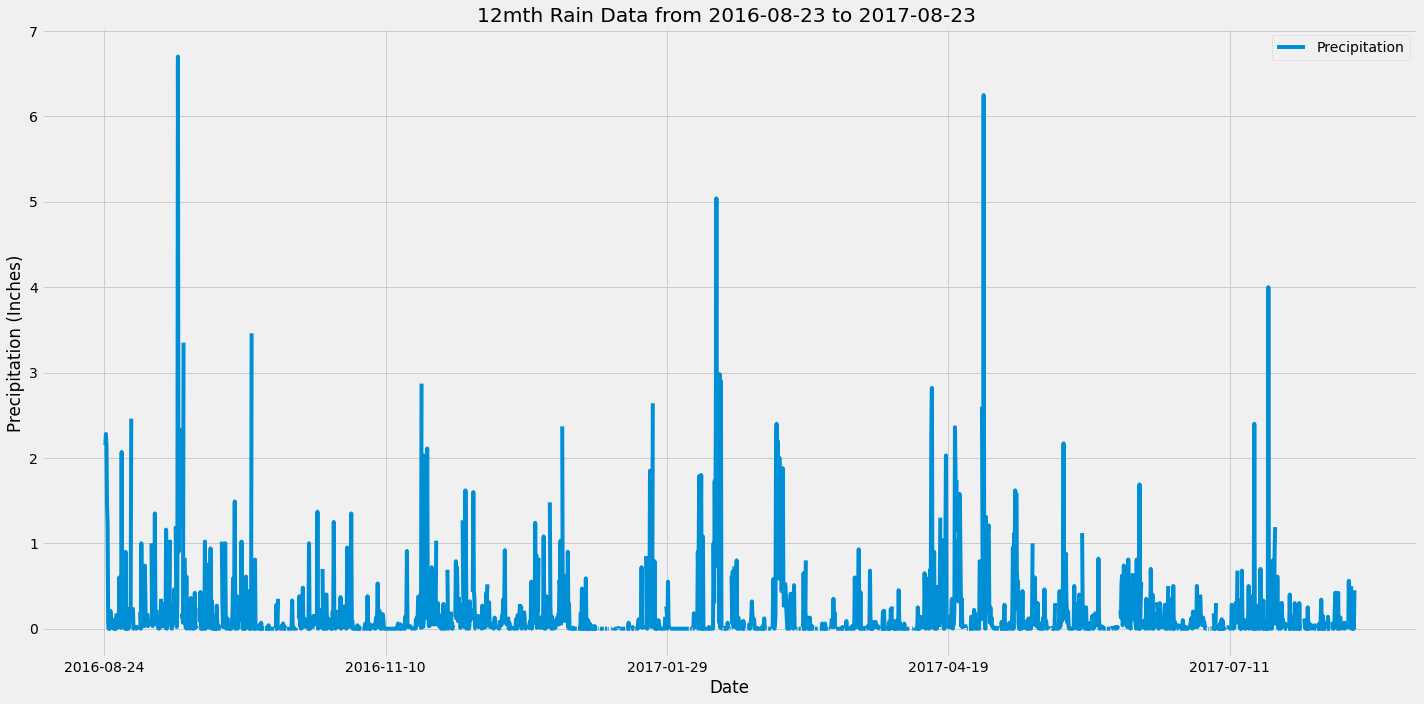

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Figuring out the last date of the dataset to pull the 12 months
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#getting the first part of the returned tuple so I can drop it in the graph title
last_date2 = last_date[0]

#figuring out the date 12 months prior (this seems like overkill, but idk)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
date = dt.datetime(2016, 8, 23)

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > date).all()

# print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results).set_index('date')

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)
df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title(f"12mth Rain Data from {query_date} to {last_date2} ")
plt.legend(['Precipitation'])
plt.tight_layout()
plt.savefig("Images/precipitation_data.png")
plt.show()

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df = df.describe()
summary_df.rename(columns={"prcp":"Precipitation"})

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [50]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).distinct().count()
print(station_count)

9


In [83]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#had to import these bad boys to get the function and descending order to work
from sqlalchemy import func
from sqlalchemy import desc

#query pulls in station in the Measurement table, counts the rows and orders them in descending order
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

activity_df = pd.DataFrame(station_activity, columns = ["Station","Activity Count"])
print(activity_df)

#query result for next session
station_activity_max = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).first()

max_station = station_activity_max[0]
print("-----")
print(f'Most Active Station: {max_station}')

       Station  Activity Count
0  USC00519281            2772
1  USC00519397            2724
2  USC00513117            2709
3  USC00519523            2669
4  USC00516128            2612
5  USC00514830            2202
6  USC00511918            1979
7  USC00517948            1372
8  USC00518838             511
-----
Most Active Station: USC00519281


In [90]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.avg(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs)
      ]
max_station_data = session.query(*sel).\
    filter(Measurement.station == max_station).all()
max_station_data

max_station_data_df = pd.DataFrame(max_station_data, columns=['station', 'average', 'minimum', 'maximum'])
max_station_data_df.set_index('station')

,average,minimum,maximum
station,,,
USC00519281,71.663781,54.0,85.0


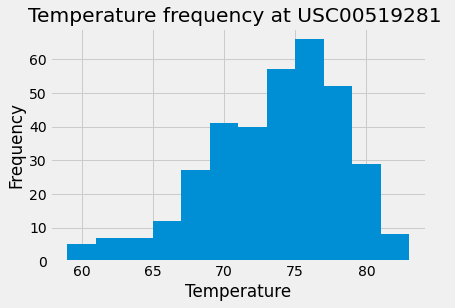

In [105]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date = dt.datetime(2016, 8, 23)

temp_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > date).\
    filter(Measurement.station == max_station).all()

# print(temp_obs)
# Save the query results as a Pandas DataFrame and set the index to the date column
df_tobs = pd.DataFrame(temp_obs).set_index('date')
plt.hist(df_tobs,bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature frequency at {max_station} ")
plt.savefig("Images/histogram.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
